another notebook

In [153]:
import rioxarray as rio
import numpy as np
import xarray as xr

from rasterio.enums import Resampling # IF you're doing BILINEAR or NEAREST too?

import geopandas as gpd

from rasterio.features import shapes
from pandas import RangeIndex

from sklearn.cluster import KMeans
from skimage import morphology#, color

import matplotlib.pyplot as plt

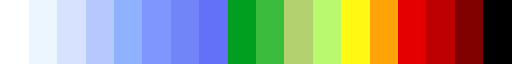

In [28]:
import cmaps
# from cmcrameri import cm as cmc
cmaps.precip2_17lev
# cmaps.wh_bl_gr_ye_re
# cmaps.WhiteBlueGreenYellowRed

In [12]:
RAIN_MAP = '../realisation_MAM_crs-OK.nc'                # yes.interpretable CRS
SUBGROUP = ''
CLUSTERS = 1#4                                          # number of regions to split the whole.region into

# OGC-WKT for HAD [taken from https://epsg.io/42106]
WKT_OGC = 'PROJCS["WGS84_/_Lambert_Azim_Mozambique",'\
    'GEOGCS["unknown",'\
        'DATUM["unknown",'\
            'SPHEROID["Normal Sphere (r=6370997)",6370997,0]],'\
        'PRIMEM["Greenwich",0,'\
            'AUTHORITY["EPSG","8901"]],'\
        'UNIT["degree",0.0174532925199433,'\
            'AUTHORITY["EPSG","9122"]]],'\
    'PROJECTION["Lambert_Azimuthal_Equal_Area"],'\
    'PARAMETER["latitude_of_center",5],'\
    'PARAMETER["longitude_of_center",20],'\
    'PARAMETER["false_easting",0],'\
    'PARAMETER["false_northing",0],'\
    'UNIT["metre",1,'\
        'AUTHORITY["EPSG","9001"]],'\
    'AXIS["Easting",EAST],'\
    'AXIS["Northing",NORTH],'\
    'AUTHORITY["EPSG","42106"]]'

yyss = np.linspace(1167500., -1177500., 470, endpoint=True)
xxss = np.linspace(1342500.,  3377500., 408, endpoint=True)

In [40]:
print(yyss.shape)
print(xxss.shape)

(470,)
(408,)


create void with CRS

In [19]:
void = np.empty( (len(yyss),len(xxss)) )
void.fill(np.nan)

# create xarray
void = xr.DataArray(data=void, dims=['y', 'x']#, name='void'
    # , coords=dict(y=(['y'], YS), x=(['x'], XS), )
    , coords=dict(y=(['y'], yyss), x=(['x'], xxss), )
    , attrs=dict(_FillValue=np.nan, units='mm', ),
    )
# void = xr.DataArray(data=void, name='rain', dims=['time','lat', 'lon']
#     , coords=dict(time=(['time'],np.r_[1000,2000,3000,4000,5000])
#     , lat=(['lat'], np.r_[1,2,3,4,5,6,7]), lon=(['lon'], np.r_[1,2,3]), )
#     , attrs=dict(_FillValue=np.nan, units='mm', ))
# assign CRS
void.rio.write_crs(rio.crs.CRS( WKT_OGC ), grid_mapping_name='spatial_ref', inplace=True)

print( void)
print( void.rio.crs )

<xarray.DataArray (y: 470, x: 408)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 1.168e+06 1.162e+06 ... -1.172e+06 -1.178e+06
  * x            (x) float64 1.342e+06 1.348e+06 ... 3.372e+06 3.378e+06
    spatial_ref  int32 0
Attributes:
    _FillValue:  nan
    units:       mm
PROJCS["WGS84_/_Lambert_Azim_Mozambique",GEOGCS["unknown",DATUM["unknown",SPHEROID["Normal Sphere (r=6370997)",6370997,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",5],PARAMETER["longitude_of_center",20],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","42106"]]


In [41]:
xile = rio.open_rasterio( RAIN_MAP , group=SUBGROUP )

# REMOVING the annoying BAND dimension (assuming we only have ONE band!)
if 'band' in list(xile.dims):
    for x in list(xile.data_vars):
        # https://stackoverflow.com/a/41836191/5885810
        xile[ x ] = xile[ x ].sel(band=1, drop=True)
    xile = xile.drop_dims(drop_dims='band')

xvar = xile.rio.grid_mapping
# actual crs
xcrs = xile.rio.crs
# # trasform4fun
# xtra = xile.rio.transform()
xile.close()

print(xile)

<xarray.Dataset>
Dimensions:   (x: 480, y: 450)
Coordinates:
  * x         (x) float64 28.02 28.07 28.12 28.17 ... 51.82 51.87 51.92 51.97
  * y         (y) float64 15.48 15.43 15.38 15.33 ... -6.875 -6.925 -6.975
    xomethin  int32 0
Data variables:
    rain      (y, x) float32 ...
    mask      (y, x) uint8 ...


In [44]:
void.rio.crs.to_string() != xcrs.to_string()

True

In [43]:


# xcrs.is_geographic
# renaming coordinates for 'easy' reprojection?
# https://www.geeksforgeeks.org/python-get-dictionary-keys-as-a-list/
c_xoid = list( void.coords.dims )
# ['y', 'x']
# ['lat', 'lon']
c_xile = list( xile.coords.dims )
# ['lat', 'lon']
# ['band', 'x', 'y']

# https://stackoverflow.com/a/176921/5885810
c_ids = list(map(lambda i:c_xile.index(i), c_xoid))

# assuming LAT goes first
# https://www.geeksforgeeks.org/python-convert-two-lists-into-a-dictionary/
# https://stackoverflow.com/a/56163051/5885810  -> rename coordinates
# https://stackoverflow.com/a/51988240/5885810 -> slicing lists
# # the line below gives WARNING
# xile = xile.rename( dict(map(lambda i,j : (i,j) ,
#     list(map(c_xile.__getitem__, c_ids)), c_xoid)) )
xile = xile.set_index(indexes=dict(zip( list(map(c_xile.__getitem__, c_ids)), c_xoid )),)

print(xile)

<xarray.Dataset>
Dimensions:   (x: 480, y: 450)
Coordinates:
  * x         (x) float64 28.02 28.07 28.12 28.17 ... 51.82 51.87 51.92 51.97
  * y         (y) float64 15.48 15.43 15.38 15.33 ... -6.875 -6.925 -6.975
    xomethin  int32 0
Data variables:
    rain      (y, x) float32 ...
    mask      (y, x) uint8 ...


In [46]:



# reprojection happens here
pile = xile.rio.reproject_match(void, resampling=Resampling.nearest )

print(pile)        

<xarray.Dataset>
Dimensions:   (x: 408, y: 470)
Coordinates:
  * x         (x) float64 1.342e+06 1.348e+06 1.352e+06 ... 3.372e+06 3.378e+06
  * y         (y) float64 1.168e+06 1.162e+06 ... -1.172e+06 -1.178e+06
    xomethin  int32 0
Data variables:
    rain      (y, x) float32 8.853 12.19 12.01 14.22 ... 527.5 527.5 526.5 526.5
    mask      (y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0 0


xporting the nc the wrong way

In [159]:

pile.to_netcdf( 'for_wrong-1.nc', mode='w')

# or

pile.to_netcdf( 'for_wrong-2.nc', mode='w',
    encoding={'rain':{'dtype':'f4','zlib':True,'complevel':9},
              'mask':{'dtype':'u1'}})#,'_FillValue':0},})



In [30]:



# some.VISUALISATION (assuming RAIN is the variable!!)
# ----------------------------------------------------




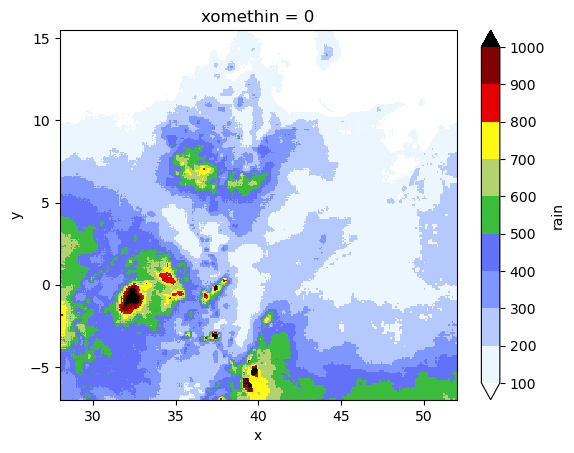

In [47]:



xile.rain.plot(cmap='precip2_17lev', levels=10,vmin=100,vmax=1000, add_colorbar=True)#, robust=True)#, ax=ax)



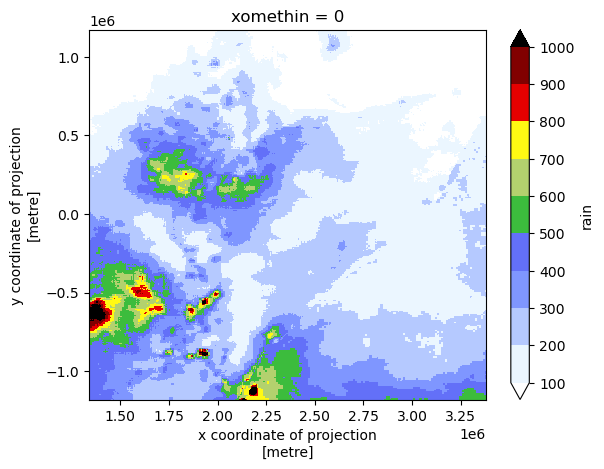

In [48]:



pile.rain.plot(cmap='precip2_17lev', levels=10,vmin=100,vmax=1000, add_colorbar=True)#, robust=True)#, ax=ax)



In [50]:



pile.rio.grid_mapping

        

'xomethin'

In [51]:


# actual crs
pile.rio.crs
        

CRS.from_wkt('PROJCS["WGS84_/_Lambert_Azim_Mozambique",GEOGCS["unknown",DATUM["unknown",SPHEROID["Normal Sphere (r=6370997)",6370997,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",5],PARAMETER["longitude_of_center",20],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","42106"]]')

In [52]:


print( xile )
print( pile )


<xarray.Dataset>
Dimensions:   (x: 480, y: 450)
Coordinates:
  * x         (x) float64 28.02 28.07 28.12 28.17 ... 51.82 51.87 51.92 51.97
  * y         (y) float64 15.48 15.43 15.38 15.33 ... -6.875 -6.925 -6.975
    xomethin  int32 0
Data variables:
    rain      (y, x) float32 6.512 6.551 5.45 5.525 ... 606.7 606.7 593.3 593.3
    mask      (y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0 0
<xarray.Dataset>
Dimensions:   (x: 408, y: 470)
Coordinates:
  * x         (x) float64 1.342e+06 1.348e+06 1.352e+06 ... 3.372e+06 3.378e+06
  * y         (y) float64 1.168e+06 1.162e+06 ... -1.172e+06 -1.178e+06
    xomethin  int32 0
Data variables:
    rain      (y, x) float32 8.853 12.19 12.01 14.22 ... 527.5 527.5 526.5 526.5
    mask      (y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0 0


DOING SEGMENTATION

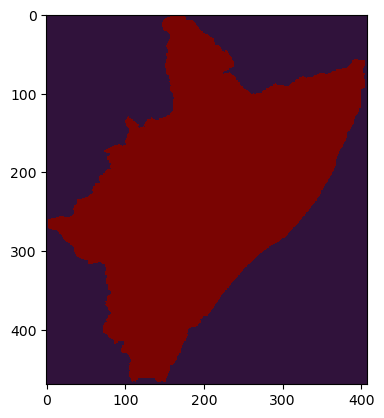

In [123]:
# reading the xported.numpy
CATCHMENT_MASK = np.load( 'tre_catchment-mask.npy' )


plt.imshow(CATCHMENT_MASK, origin='upper', cmap='turbo', interpolation='none')#.resampled(3))

In [105]:

# # FOR A MASK IN THE WHOLE [RECTANGULAR] DOMAIN USE:
#     mask_regn = np.ma.MaskedArray( pile.rain.data.copy(), False )

In [79]:

mask_regn = np.ma.MaskedArray( pile.rain.data.copy(), ~CATCHMENT_MASK.astype('bool') )
# ... in the line below (previous cases) BAND was removed!
# mask_regn = np.ma.MaskedArray( real.rain['band'==1,:].data.copy(), ~CATCHMENT_MASK.astype('bool') )

print(mask_regn )

[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]



REGIONALIZATION

In [54]:

CLUSTERS = 4                                          # number of regions to split the whole.region into


In [80]:
REG = mask_regn.copy()
N_C = CLUSTERS

In [81]:


# nans outside mask
REG[ REG.mask ] = np.nan
# ravel and indexing
ravl = REG.ravel()
idrs = np.arange(len(ravl))[ ~np.isnan( ravl ) ]
# transform the non-void (RGB?) field into 1D.numpy
X = ravl[ idrs ].data.reshape(-1, 1)
# kmeans = KMeans(n_clusters=3, init=np.array([[70],[220],[800]]), n_init='auto').fit( X )
kmeans = KMeans(n_clusters=N_C, n_init=11, random_state=None).fit( X )

# # we're interested in the classes.. not in the actual means
#     segmented_img = kmeans.cluster_centers_[ kmeans.labels_ ]
#     # bsctransform to 2D.numpy
#     segmented_img = segmented_img.reshape( REG.shape )

# expand the result into void-array
ravl[ idrs ] = kmeans.labels_
LAB = ravl.reshape( REG.shape ).data
# plt.imshow(LAB, origin='lower', cmap='turbo', interpolation='none')#.resampled(3))
# # plt.savefig('realization.pdf', bbox_inches='tight',pad_inches=0.02)
# # plt.close() ; plt.clf()

# https://stackoverflow.com/a/25715954/5885810  # np.object to np.string
# https://www.w3resource.com/numpy/string-operations/strip.php  # strip np.string.arrays
KAT = np.char.strip(kmeans.get_feature_names_out().astype('U'), 'kmeans')

In [82]:
print( LAB )

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


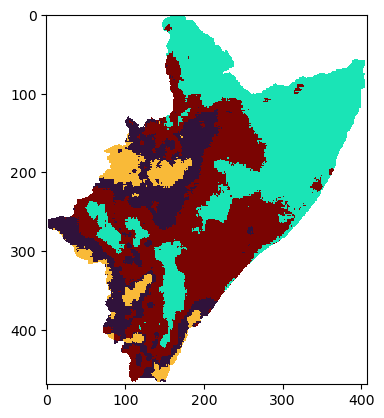

In [84]:
plt.imshow(LAB, origin='upper', cmap='turbo', interpolation='none')#.resampled(3))
# plt.savefig('realization.pdf', bbox_inches='tight',pad_inches=0.02)
# plt.close() ; plt.clf()

In [150]:
cdic= dict(zip(KAT, kmeans.cluster_centers_))
cdic

{'0': array([371.8593], dtype=float32),
 '1': array([122.04943], dtype=float32),
 '2': array([578.6911], dtype=float32),
 '3': array([233.32787], dtype=float32)}

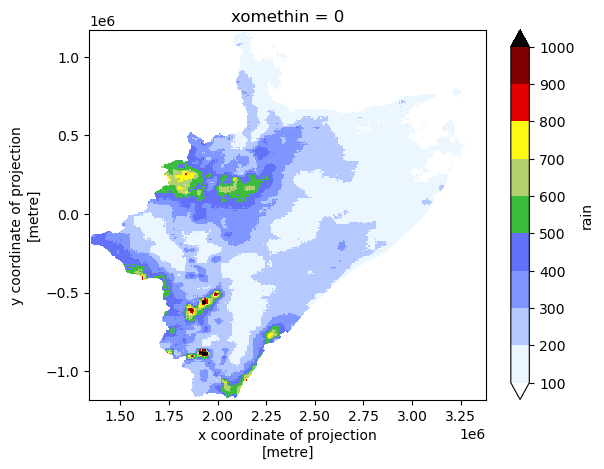

In [104]:
pile.rain.where(~np.isnan( REG.data ), np.nan).plot(cmap='precip2_17lev', levels=10,vmin=100,vmax=1000, add_colorbar=True)#, robust=True)#, ax=ax)

#~ MORPHOLOGICAL FILTERING via SCIKIT-IMAGE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

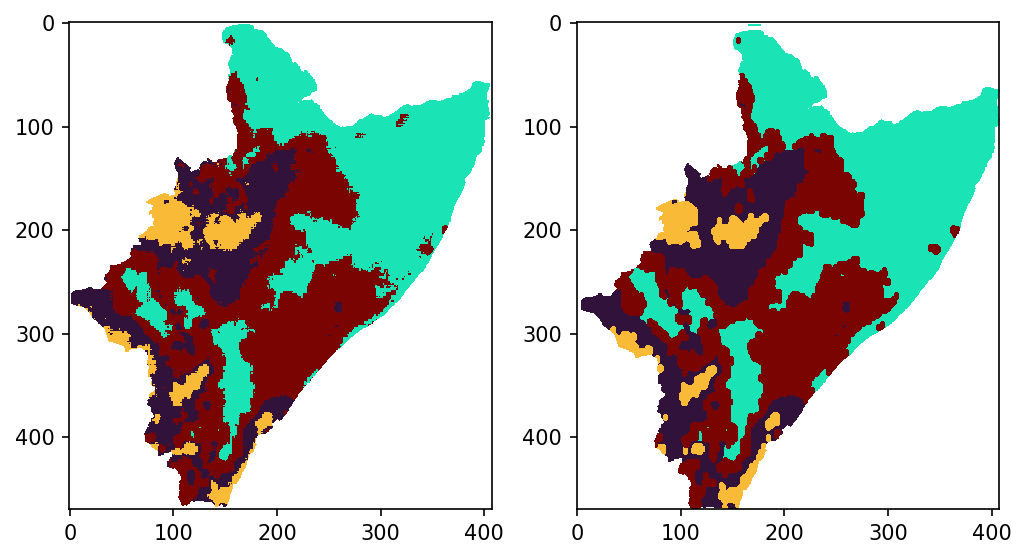

In [135]:
new = morphology.opening(LAB, morphology.ellipse(2,3))

fig, ax = plt.subplots(1,2, figsize=(8,5), dpi=150)
ax[0].imshow(LAB, origin='upper', cmap='turbo', interpolation='none')
ax[1].imshow(new, origin='upper', cmap='turbo', interpolation='none')

In [136]:

mopen = new
# mopen = LAB

maskssss to numpys

In [137]:
# NUMPY to SHAPE
# .rio.transform() IS QUITE OF THE ESSENCE HERE!

lopen = list( shapes(mopen, mask=CATCHMENT_MASK, connectivity=4, transform=pile.rio.transform()) )
# lopen = list( shapes(mopen, mask=BUFFRX_MASK, connectivity=4, transform=real.rio.transform()) )



In [138]:

# remove NAN.regions??
# https://stackoverflow.com/a/25050572/5885810
# https://stackoverflow.com/a/3179137/5885810
lopen = [x for x, y in zip(lopen, ~np.isnan(list(zip(*lopen))[-1])) if y]
lopen = list(map(lambda x:dict(geometry=x[0], properties={'label':f'region{int(x[-1])}', }), lopen))
# into GEOPANDAS
feats = gpd.GeoDataFrame.from_features( {'type':'FeatureCollection','features':lopen} )
# # line below is an alternative... BUT you mig have troubles grouping it
# feats = gpd.GeoDataFrame.from_dict( list( shapes(mopen, mask=BUFFRX_MASK, connectivity=4, transform=real.rio.transform()) ),)



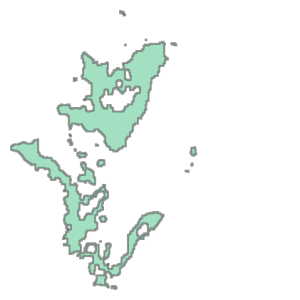

In [139]:


# grouping to retrieve just the CLUSTER.masks (the output is a Series)
nasks = feats.groupby(by='label').apply(lambda x: x.unary_union)
nasks[0]
# nasks[1]
# nasks[2]
# nasks[3]



In [141]:


# # do we obtain HAD if merging all masks?
# feast.unary_union

# turn-back them into GeoPandas
masks = gpd.GeoDataFrame(geometry=nasks)
# masks.geometry.iloc[0]
# masks.geometry.loc['region0']
# masks.loc['region0'].geometry
# masks.geometry.xs('region0')

**##---------------------------------------------------##**

THE FOLLOWING ARE A COUPLE OF UNNECESSARY BLOCKS

In [154]:
real = pile.copy(deep=True)

# https://realpython.com/iterate-through-dictionary-python/
for keys, values in\
    dict(zip(['catchm'      ,'cacth'   ,'kmeans','region'],
             [CATCHMENT_MASK,CATCHMENT_MASK,npreg   ,mopen   ])).items():
    real[keys] = xr.DataArray(values, coords=void.coords, dims=void.coords.dims)
    # real[keys] = xr.DataArray(values, coords=real.coords, dims=real.coords.dims)
# trims "real['region']"
# trimming around the CATCHMENT_MASK is what we want; as we compute PTOT within "catchm"
real['region'] = xr.where(real.catchm==1, real.region, -1)
# real['region'] = xr.where(real.buffer==1, real.region, -1) #-trims around the BUFFER -> (this we want NOT!)

#-THESE 3 vars ARE IN THE ORDER OF cdic.keys()
# new means (regions inside the HAD)
# old_ks = list(map(lambda x:real.rain.where(real.kmeans==int(x)).mean().data, cdic.keys()))
new_ks = list(map(lambda x:real.rain.where(real.catchm==1, np.nan).where(
    real.kmeans==int(x)).mean().data, cdic.keys()))
# numpy masks
# ... 1st transform K-mean into 1s (because of the 0 K-mean); and the assign 0 everywhere else
reg_np = list(map(lambda x:
    real.region.where(real.region!=int(x), 1).where(real.region==int(x), 0).data.astype('u1'), cdic.keys()))
# shapes
# # the line below are "pandas.core.series.Series"
# zhapez = list(map(lambda x:masks.loc[f'region{int(x)}'], cdic.keys()))
# ...in case "pandas.core.series.Series" try converting them into "geopandas.geodataframe.GeoDataFrame"
zhapez = list(map(lambda x:gpd.GeoDataFrame(
    geometry=masks.loc[f'region{int(x)}'], crs=void.rio.crs).set_index(RangeIndex(0,1,1)), cdic.keys()))
# zhapez = list(map(lambda x:gpd.GeoDataFrame(geometry=masks.loc[f'region{int(x)}']).set_index(RangeIndex(0,1,1)), cdic.keys()))
# grouping the output into a dict
output = dict(zip(('mask','npma','rain'),(zhapez, reg_np, new_ks)))
output['kmeans'] = xr.where(real.catchm==1, real.kmeans, -1).data.astype('i1')

In [157]:
output

{'mask': [                                            geometry
  0  MULTIPOLYGON (((1985000.000 -835000.000, 19900...,
                                              geometry
  0  MULTIPOLYGON (((1945000.000 -815000.000, 19450...,
                                              geometry
  0  MULTIPOLYGON (((1875000.000 -915000.000, 18700...,
                                              geometry
  0  MULTIPOLYGON (((1935000.000 -985000.000, 19300...],
 'npma': [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
     

**##---------------------------------------------------##**